## <span style="color:black"> *Lung Cancer Dataset Machine Learning Models* </span>

## Name: <span style="color:blue"> *Joseph Pollard* </span>

In [7]:
#Imported from beginning of Homework 7: Perceptrons

from typing import List, Dict, Tuple, Callable
import os
import gc
import traceback
import warnings
from pdb import set_trace
import sklearn

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Imported from later in Homework 7: Perceptrons
from sklearn.preprocessing import StandardScaler

#Imported Lung Cancer Risk Dataset from Hugging Face (link: https://huggingface.co/datasets/nateraw/lung-cancer)

df = pd.read_csv("survey_lung_cancer.csv")
print(df.head())
print(df.columns)

df_encoded = df.copy()

# Convert all YES/NO columns automatically
for col in df_encoded.columns:
    if df_encoded[col].dtype == object:
        unique_vals = df_encoded[col].unique()
        if set(unique_vals) == {"YES", "NO"}:
            df_encoded[col] = df_encoded[col].map({"YES": 1, "NO": 0})

# Convert Gender M/F → 1/0
df_encoded["GENDER"] = df_encoded["GENDER"].map({"M": 1, "F": 0})

# Convert target column to numeric
df_encoded['LUNG_CANCER'] = df['LUNG_CANCER'].map({"YES": 1, "NO": 0})

# Fix the label column before splitting
df_encoded['LUNG_CANCER'] = df['LUNG_CANCER'].map({"YES": 1, "NO": 0})

# Drop any leftover unknown rows
df_encoded = df_encoded.dropna(subset=['LUNG_CANCER'])

# Make sure it's integer
df_encoded['LUNG_CANCER'] = df_encoded['LUNG_CANCER'].astype(int)

# Confirm encoding applied correctly
print(df["LUNG_CANCER"].unique())
print(df["LUNG_CANCER"].value_counts())

  GENDER  AGE  SMOKING  YELLOW_FINGERS  ANXIETY  PEER_PRESSURE  \
0      M   69        1               2        2              1   
1      M   74        2               1        1              1   
2      F   59        1               1        1              2   
3      M   63        2               2        2              1   
4      F   63        1               2        1              1   

   CHRONIC DISEASE  FATIGUE   ALLERGY   WHEEZING  ALCOHOL CONSUMING  COUGHING  \
0                1         2         1         2                  2         2   
1                2         2         2         1                  1         1   
2                1         2         1         2                  1         2   
3                1         1         1         1                  2         1   
4                1         1         1         2                  1         2   

   SHORTNESS OF BREATH  SWALLOWING DIFFICULTY  CHEST PAIN LUNG_CANCER  
0                    2                      

## <span style="color:black"> *Data Visualization* </span>

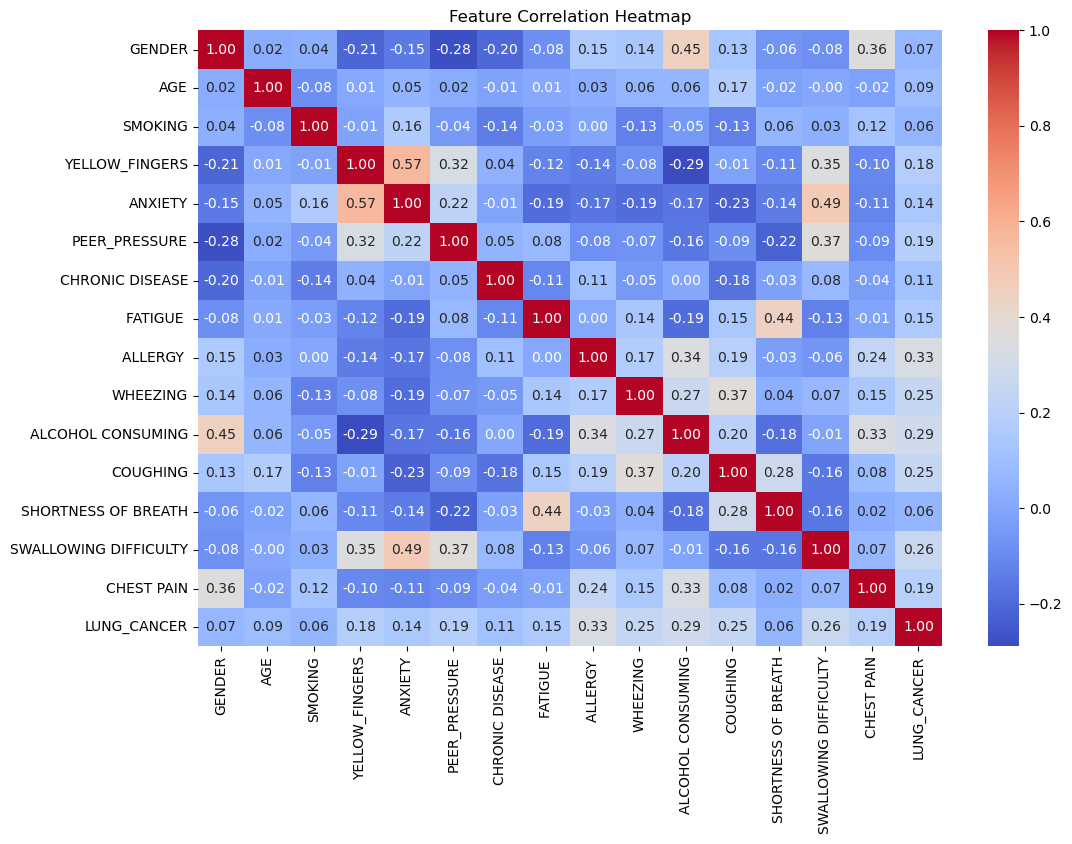

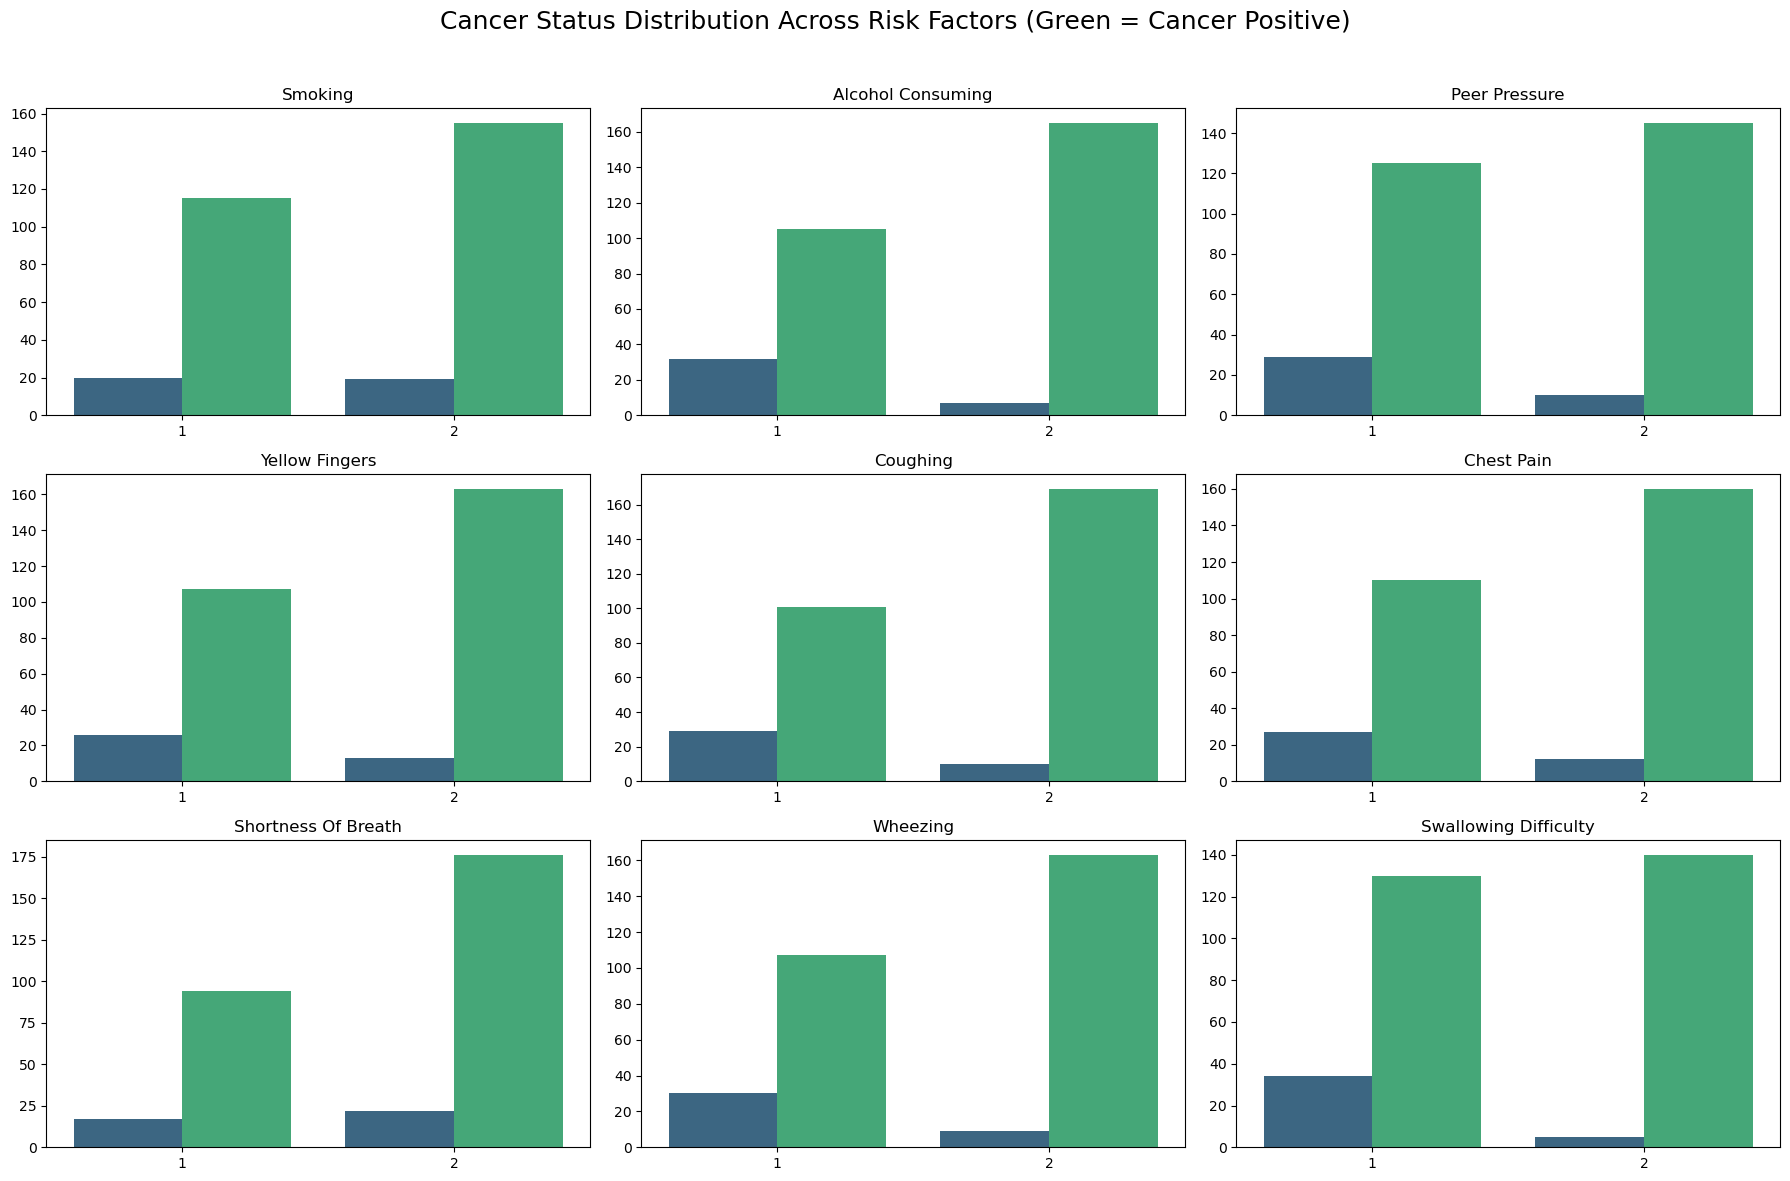

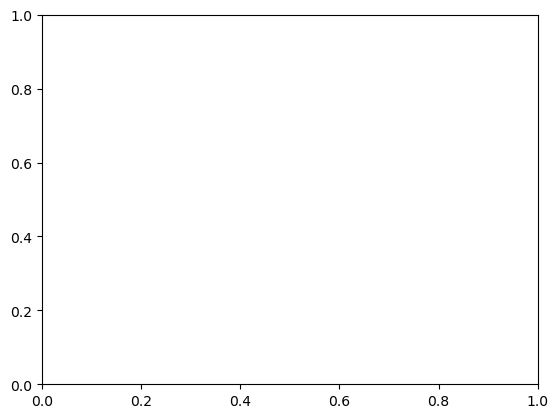

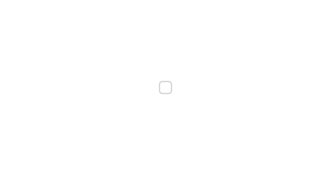

In [8]:
#Correlation map based on encoded DataFrame

plt.figure(figsize=(12, 8))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Count plots based on symptoms, habits and cancer status
cols = ['SMOKING', 'ALCOHOL CONSUMING', 'PEER_PRESSURE', 'YELLOW_FINGERS', 'COUGHING', 'CHEST PAIN', 'SHORTNESS OF BREATH',
        'WHEEZING', 'SWALLOWING DIFFICULTY']

n_cols = 3 # number of plots per row (adjust if needed)
n_rows = int(np.ceil(len(cols) / n_cols))

plt.figure(figsize=(18, 12))

for i, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.countplot(data=df_encoded, x=col, hue='LUNG_CANCER', palette='viridis')
    plt.title(col.replace("_", " ").title())
    plt.xlabel("")  # cleaner look
    plt.ylabel("")  # cleaner look
    plt.legend([],[], frameon=False)  # hide duplicate legends

# Add a single legend + title
plt.suptitle("Cancer Status Distribution Across Risk Factors (Green = Cancer Positive)", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Add one shared legend outside the plot
handles, labels = plt.gca().get_legend_handles_labels()
plt.figure(figsize=(4,2))
plt.legend(handles, ["No Cancer", "Cancer"], loc='center')
plt.axis('off')
plt.show()

## <span style="color:black"> *Lung Cancer Dataset Machine Learning Models* </span>

In [9]:
#Perceptron Functions (Taken from Homework 7)

import numpy as np
from typing import List, Tuple

def binarize_classes(
    X: np.ndarray,
    y: np.ndarray,
    pos_class: List[int], 
    neg_class: List[int]
) -> Tuple[np.ndarray, np.ndarray]:
    """ Converts data into a one-vs-all or one-vs-one problem
        according to labels passed as pos or neg.

        Args:
            X: Input data given as matrix

            y: Labels corresponding to input data given as 1D vector

            pos_class: list of labels that will be used for 
                the positive class.

            neg_class: list of labels that will be used for 
                the negative class.

        Returns:
            Two arrays where the 1st corresponds to the data
            given as a matrix and the 2nd corresponds to the
            new labels given as a 1D vector.
    """
    assert isinstance(X, np.ndarray), f"X is not a NumPy array, got type {type(X)}."
    assert isinstance(y, np.ndarray), f"y is not a NumPy array, got type {type(y)}."
    
    X = X.copy()
    y = y.copy()
    
    # TODO 2.1: Find positive class samples and labels
    pos_mask = np.isin(y, pos_class)
    X_pos = X[pos_mask]
    y_pos = np.ones(X_pos.shape[0])  # Set labels of positive class to 1
    
    # TODO 2.2: Find negative class samples and labels
    neg_mask = np.isin(y, neg_class)
    X_neg = X[neg_mask]
    y_neg = -np.ones(X_neg.shape[0])  # Set labels of negative class to -1
    
    # Combine positive and negative samples
    X_combined = np.vstack([X_pos, X_neg])
    y_combined = np.hstack([y_pos, y_neg])
    
    return X_combined, y_combined

from sklearn.model_selection import train_test_split
def get_train_valid_test_data(
    X: np.ndarray, 
    y: np.ndarray, 
):
    """ Randomizes and then splits the data into train, validation, and test sets.

        Args:
            X: Data given as a 2D matrix

            y: Labels given as a vector 
    """
    X_trn, X_tst, y_trn, y_tst = train_test_split(X, y, train_size=.8, random_state=42)
    X_trn, X_vld, y_trn, y_vld = train_test_split(X_trn, y_trn, train_size=.8, random_state=42)

    return X_trn, y_trn, X_vld, y_vld, X_tst, y_tst

def get_preprocessed_data(pos_class: List[int], neg_class: List[int]):
    # Separate features and labels
    X = df_encoded.drop(columns='LUNG_CANCER').values
    y = df_encoded['LUNG_CANCER'].values
    
    # Convert labels to +1 / -1 for perceptron learning
    X, y = binarize_classes(X, y, pos_class, neg_class)
    
    # Split
    X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_train_valid_test_data(X, y)
    
    # Normalize
    scaler = StandardScaler()
    X_trn = scaler.fit_transform(X_trn)
    X_vld = scaler.transform(X_vld)
    X_tst = scaler.transform(X_tst)

    # Add bias term
    X_trn = np.hstack([np.ones((X_trn.shape[0], 1)), X_trn])
    X_vld = np.hstack([np.ones((X_vld.shape[0], 1)), X_vld])
    X_tst = np.hstack([np.ones((X_tst.shape[0], 1)), X_tst])

    return X_trn, y_trn.flatten(), X_vld, y_vld.flatten(), X_tst, y_tst.flatten()


def accuracy(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Computes the accuracy between two 1D vectors

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

        Return:
            A float corresponding to the accuracy
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency

    # TODO 4
    samples = len(y)
    correct = np.sum(y == y_hat)
            
    return (correct / samples)

def plot_confusion_matrix(
    y: np.ndarray, 
    y_hat: np.ndarray, 
    class_name_key: Dict[int, str] = None
) -> pd.DataFrame:
    """ Plots a pretty and labeld version of Sklerarn's confusion matrix

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

            class_name_key: A dictionary where each key corresponds to 
                a label in y and the values corresponding to string name 
                for said label. This name will be displayed when plotting.

        Returns:
            A confusion matrix casted as a DataFrame
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency
    
    # TODO 5
    from sklearn.metrics import confusion_matrix
    cfm = sklearn.metrics.confusion_matrix(y, y_hat)
    
    labels = np.sort(np.unique(y))
    if class_name_key is not None:
        classes = []
        for l in labels:
            class_name = class_name_key.get(l, l)
            classes.append(class_name)
        labels = classes
        
    columns, index = labels, labels
    cfm_df = pd.DataFrame(cfm, index=index, columns=columns)
    sns.heatmap(cfm_df, annot=True)

    return cfm_df

def ppv(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Compute the PPV or precision score

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

        Returns:
            A float corresponding to the PPV value.
    """
    y =  y.flatten() # reshape to make 1D vector for consistency
    y_hat = y_hat.flatten() # reshape to make 1D vector for consistency

    cm = sklearn.metrics.confusion_matrix(y, y_hat)
    TP = cm[1, 1]  # True Positives are at index (1, 1)
    FP = cm[0, 1]  # False Positives are at index (0, 1)
    
    if TP + FP == 0:
        return 0.0  # If no positive predictions, return 0 to avoid division by zero
    
    ppv_value = TP / (TP + FP)
    return ppv_value

def tpr(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Compute the TPR or recall score

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

        Returns:
            A float corresponding to the TPR value.
    """
    # TODO 7
    cm = sklearn.metrics.confusion_matrix(y, y_hat)
    TP = cm[1, 1]  # True Positives are at index (1, 1)
    FN = cm[1, 0]  # False Positives are at index (0, 1)
    
    return (TP / (TP + FN))

def tnr(y: np.ndarray, y_hat: np.ndarray) -> float:
    """ Compute the TNR or specificity score

        Args:
            y: Ground truth labels given as a 1D vector

            y_hat: Predicted labels given as a 1D vector

        Returns:
            A float corresponding to the TNR value.
    """
    # TODO 8
    cm = sklearn.metrics.confusion_matrix(y, y_hat)
    TN = cm[0, 0]  # True Positives are at index (1, 1)
    FP = cm[0, 1]  # False Positives are at index (0, 1)
    
    return (TN / (TN + FP))

In [10]:
# Perceptron Class (From Homework 7)

class Perceptron():
    """ Performs binary classification using Rosenblatt's perceptron
    
        Attributes:

            alpha: learning rate or step size
 
            epochs: Number of epochs to run for mini-batch
                gradient descent
                
            seed: Seed to be used for NumPy's RandomState class
                or universal seed np.random.seed() function.

            w: Vector of weights 

            trn_acc: List that stores training accuracy for each epoch.

            vld_acc: List that stores validation accuracy for each epoch.
    """
    def __init__(
        self, 
        alpha: float,
        seed: int = 0,
        epochs: int = 1,
    ):
        self.alpha = alpha
        self.epochs = epochs
        self.seed = seed
        self.w = None
        self.trn_acc = None
        self.vld_acc = None

    def fit(
         self, X: np.ndarray, 
         y: np.ndarray, 
         X_vld: np.ndarray=None, 
         y_vld: np.ndarray=None
     ) -> object:
        """ Train the perceptron to find optimal weights

            Args:
                X: Training data given as a 2D matrix

                y: Training labels given as a 2D column vector
                
            Returns:
                The class's own object reference. 
        """
        np.random.seed(self.seed) # Set seed for reproducibility
        self.trn_acc = []
        self.vld_acc = []
        
        # TODO 9.1 - 9.2

        self.w = np.zeros((X.shape[1], 1))

        #testing flattening
        X.flatten()
        X_vld.flatten()
        y.flatten()
        y_vld.flatten()

        # Loop over epochs
        for epoch in range(self.epochs):
            misclassified = 0  # Track number of misclassified samples
    
            # Loop through each sample in the dataset
            for n in range(X.shape[0]):
                x_n = X[n].reshape(-1, 1)  # Reshape to column vector (M x 1)
                y_n = y[n]
            
                # Compute the prediction: z = w^T * x_n
                z = np.dot(X[n], self.w)  # (M,) . (M, 1) => scalar result
                y_hat = np.sign(z)  # Predict the class (sign of z)
            
                # If prediction is incorrect, update weights
                if y_hat != y_n:
                    misclassified += 1
                    self.w = self.w + self.alpha * y_n * x_n  # Update weights (M x 1)
        
            # Calculate accuracy on the training data after each epoch
            train_accuracy = self.evaluate_accuracy(X, y)
            self.trn_acc.append(train_accuracy)

            # If validation data is provided, calculate validation accuracy
            if X_vld is not None and y_vld is not None:
                valid_accuracy = self.evaluate_accuracy(X_vld, y_vld)
                self.vld_acc.append(valid_accuracy)

            # Early stopping if no misclassified samples in this epoch
            if misclassified == 0:
                print(f"Converged after {epoch + 1} epochs!")
                break

        return self
        
    def predict(self, X: np.ndarray) -> np.ndarray:
        """ Make predictions using learned weights

            Args:
                X: Testing data given as a 2D matrix

            Returns:
                A 2D column vector of predictions for each data sample in X
        """
        z = np.dot(X, self.w)
        return np.sign(z).flatten()

    def evaluate_accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """ Calculate accuracy of the model on given data
        
            Args:
                X: Features of the dataset
                y: Ground truth labels of the dataset
            
            Returns:
                A float representing the accuracy
        """
        y_hat = self.predict(X)  # Get predicted labels
        return np.mean(y_hat == y)  # Compare predictions to true labels

Unique values in LUNG_CANCER column: [1 0]
Value counts:
 LUNG_CANCER
1    270
0     39
Name: count, dtype: int64
[np.float64(0.9035532994923858), np.float64(0.8527918781725888), np.float64(0.8984771573604061)]


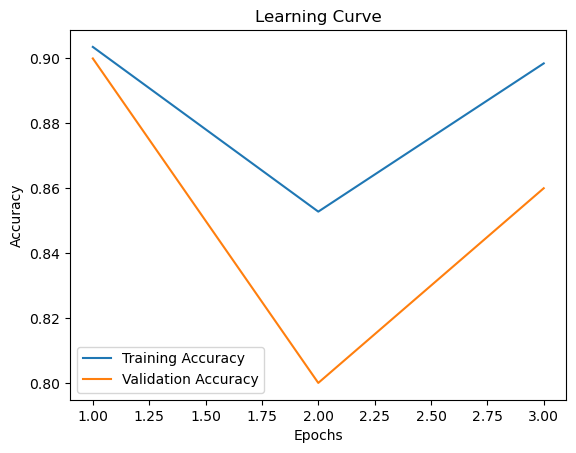


=== Perceptron Performance ===
Training Accuracy: 0.8984771573604061
Validation Accuracy: 0.86
Test Accuracy: 0.9032258064516129
Accuracy: 0.9032258064516129
TPR: 0.9622641509433962
TNR: 0.5555555555555556
PPV: 0.9272727272727272


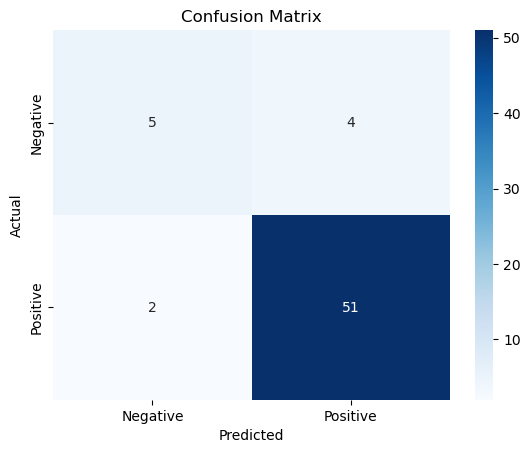

In [17]:
# Perceptron setup and testing

print("Unique values in LUNG_CANCER column:", df_encoded["LUNG_CANCER"].unique())
print("Value counts:\n", df_encoded["LUNG_CANCER"].value_counts())

# TODO 10.1-10.5
p = Perceptron(alpha=0.3, epochs=3)
X_trn, y_trn, X_vld, y_vld, X_tst, y_tst = get_preprocessed_data([1], [0])

y_trn = y_trn.flatten()
y_tst = y_tst.flatten()
y_vld = y_vld.flatten()

p.fit(X_trn, y_trn, X_vld, y_vld)

print(p.trn_acc)
# Step 3: Plot the learning curve
plt.plot(range(1, len(p.trn_acc) + 1), p.trn_acc, label='Training Accuracy')
plt.plot(range(1, len(p.vld_acc) + 1), p.vld_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.show()

# Step 4: Compute and display the performance metrics on the testing data

print("\n=== Perceptron Performance ===")

# Training accuracy
train_acc = p.evaluate_accuracy(X_trn, y_trn)
print(f"Training Accuracy: {train_acc}")

# Validation accuracy
val_acc = p.evaluate_accuracy(X_vld, y_vld)
print(f"Validation Accuracy: {val_acc}")

# Test accuracy
test_acc = p.evaluate_accuracy(X_tst, y_tst)
print(f"Test Accuracy: {test_acc:}")

print(f"Accuracy: {acc}")
print(f"TPR: {tpr}")
print(f"TNR: {tnr}")
print(f"PPV: {ppv}")


# Step 5: Plot the confusion matrix
cm = sklearn.metrics.confusion_matrix(y_tst, y_hat)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## <span style="color:black"> *Linear Regression Model and Output* </span>

Epoch 100/200 | Loss: 0.0302
Epoch 200/200 | Loss: -0.1106

=== Logistic Regression Performance ===
Training Accuracy: 0.7715736040609137
Validation Accuracy: 0.8
Test Accuracy: 0.7096774193548387


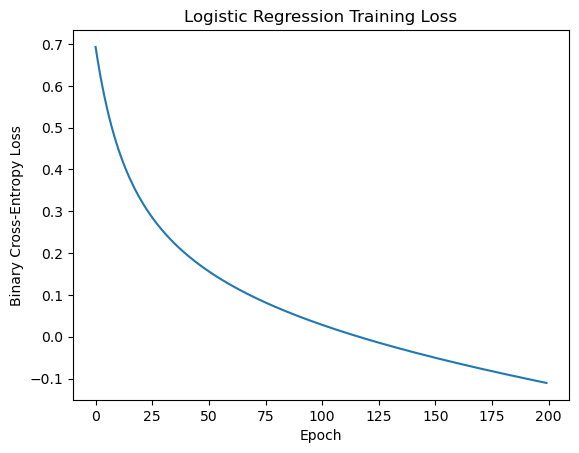

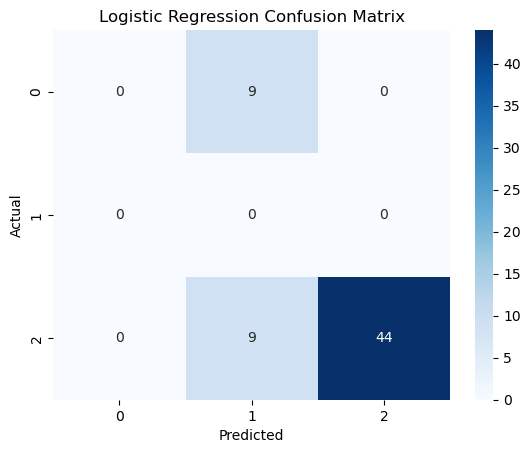

In [22]:
# Linear Regression Setup

class LogisticRegression:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.lr = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.loss_history = []

    def sigmoid(self, z):
        # Prevent overflow errors
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

    def compute_loss(self, y, y_pred):
        # Binary Cross-Entropy Loss
        epsilon = 1e-10  # prevents log(0)
        return -np.mean(y*np.log(y_pred+epsilon) + (1-y)*np.log(1-y_pred+epsilon))

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize parameters
        self.weights = np.zeros(n_features)
        self.bias = 0

        for i in range(self.epochs):
            # Linear model + sigmoid
            z = np.dot(X, self.weights) + self.bias
            y_pred = self.sigmoid(z)

            # Gradients
            dw = (1/n_samples) * np.dot(X.T, (y_pred - y))
            db = (1/n_samples) * np.sum(y_pred - y)

            # Update parameters
            self.weights -= self.lr * dw
            self.bias -= self.lr * db

            # Track loss
            loss = self.compute_loss(y, y_pred)
            self.loss_history.append(loss)

            if (i+1) % 100 == 0:
                print(f"Epoch {i+1}/{self.epochs} | Loss: {loss:.4f}")

    def predict_proba(self, X):
        # Outputs probabilities between 0 and 1
        return self.sigmoid(np.dot(X, self.weights) + self.bias)

    def predict(self, X, threshold=0.5):
        # Convert probabilities to class labels
        return (self.predict_proba(X) >= threshold).astype(int)

    def accuracy(self, X, y):
        y_pred = self.predict(X)
        return np.mean(y_pred == y)

logreg = LogisticRegression(learning_rate=0.1, epochs=200)
logreg.fit(X_trn, y_trn)

print("\n=== Logistic Regression Performance ===")
print("Training Accuracy:", logreg.accuracy(X_trn, y_trn))
print("Validation Accuracy:", logreg.accuracy(X_vld, y_vld))
print("Test Accuracy:", logreg.accuracy(X_tst, y_tst))

# Plot training loss curve
import matplotlib.pyplot as plt
plt.plot(logreg.loss_history)
plt.title("Logistic Regression Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Cross-Entropy Loss")
plt.show()

#Confusion Matrix plotting
cm = sklearn.metrics.confusion_matrix(y_tst, logreg.predict(X_tst))

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()